In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from face_verification.preprocessing import (
    split_identities,
    find_unique_identities,
    find_paths_with_identities,
)
from face_verification.dataloaders import create_dataloader
from face_verification.models.face_verification import ArcFace, MobileNetV2
from face_verification.trainers import ArcFaceTrainer
from face_verification.metrics import Accuracy

In [2]:
IMAGE_DIR = Path("meglass/")
VALID_SIZE = 0.1
TEST_SIZE = 0.1
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 8
RANDOM_STATE = 12
LEARNING_RATE = 1e-5
N_EPOCHS = 100

In [3]:
image_paths = list(IMAGE_DIR.glob("*.jpg"))

In [4]:
unique_identities = find_unique_identities(image_paths)

In [5]:
train_identities, valid_identities, test_identities = split_identities(
    unique_identities, VALID_SIZE, TEST_SIZE, RANDOM_STATE
)

In [6]:
train_identities = train_identities

In [7]:
train_paths = find_paths_with_identities(image_paths, train_identities)
valid_paths = find_paths_with_identities(image_paths, valid_identities)
test_paths = find_paths_with_identities(image_paths, test_identities)

In [8]:
train_loader = create_dataloader(train_paths, IMAGE_SIZE, BATCH_SIZE)
valid_loader = create_dataloader(valid_paths, IMAGE_SIZE, BATCH_SIZE)
test_loader = create_dataloader(test_paths, IMAGE_SIZE, BATCH_SIZE)

In [9]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

4713
618
660


In [10]:
train_iter = iter(train_loader)
image_batch, label_batch = next(train_iter)

In [11]:
print(image_batch.shape)
print(label_batch.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1251])


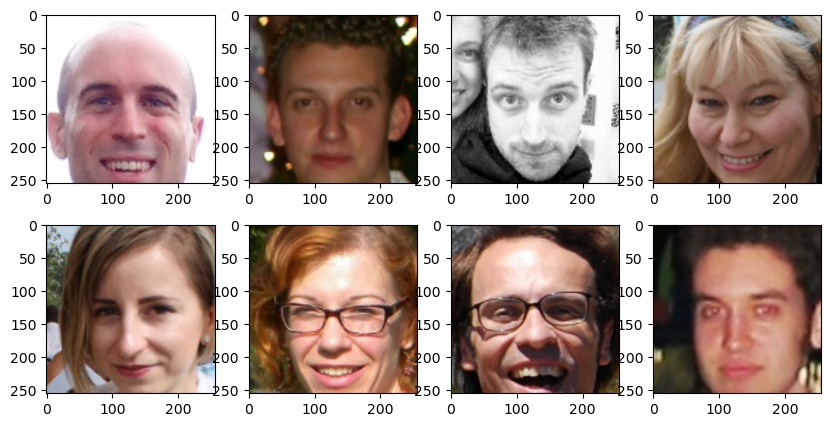

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
for axis, image in zip(axes.flatten(), image_batch.permute(0, 2, 3, 1)):
    axis.imshow(image)

In [13]:
backbone = MobileNetV2()
arcface = ArcFace(backbone, len(train_identities), margin=0.125, scale_factor=8)

In [14]:
trainable_params = [
    param for param in arcface.parameters() if param.requires_grad
]
optimizer = torch.optim.Adam(trainable_params, LEARNING_RATE)

In [15]:
trainer = ArcFaceTrainer(
    arcface,
    optimizer=optimizer,
    metrics=[Accuracy()]
)

In [ ]:
trainer.train(train_loader, valid_loader, N_EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4713 [00:00<?, ?it/s]

In [ ]:
trainer.test(test_loader)